In [1]:
from resnet164 import ResNet164
from utils import load_mnist
import numpy as np
import tensorflow as tf
import h5py
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
def evaluate(prediction, true_label):
    pred_indices = np.argmax(prediction, 1)
    true_indices = np.argmax(true_label, 1)
    return np.mean(pred_indices == true_indices)

In [9]:
def SOFTMAX(s_):
    return np.exp(s_) / np.matmul(np.ones((1, s_.shape[0])), np.exp(s_)) 

In [12]:
def knowledge_distillation_loss(y_true, y_pred, alpha):

    # Extract the one-hot encoded values and the softs separately so that we can create two objective functions
    y_true, y_true_softs = y_true[: , :nb_classes], y_true[: , nb_classes:]
    
    y_pred, y_pred_softs = y_pred[: , :nb_classes], y_pred[: , nb_classes:]
    
    loss =(alpha*tf.keras.losses.categorical_crossentropy(y_true,y_pred) +
           tf.keras.losses.categorical_crossentropy(y_true_softs, y_pred_softs))
    return loss

def acc(y_true, y_pred):
    y_true = y_true[:, :nb_classes]
    y_pred = y_pred[:, :nb_classes]
    return tf.keras.metrics.categorical_accuracy(y_true, y_pred)

In [3]:
#Data already normalized.
(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_mnist()
# print(x_train.shape)
# print(y_train.shape)
# print(x_test.shape)
# print(y_test.shape)

In [4]:
#Create teacher model: We will use the ResNet164() model, it shows a good accuracy
#we want it exclusively for getting the logits for building the student model.
teacher_model = ResNet164()
#remember Loss function during model training: loss = 'categorical_crossentropy' => logloss .
teacher_model.compile()
teacher_model.load_weights('ResNet164.h5')

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
# "big model" output_layer.
teacher_train_logits = teacher_model.predict(x_train, verbose = 1)
teacher_test_logits = teacher_model.predict(x_test, verbose = 1)

10000/10000 [==============================] - 423s 42ms/step


In [6]:
#checking accuracy
#the predicted class for the first image:
#print(np.argmax(teacher_test_logits[0]))
#the first image: >> correct classification
#plt.imshow(x_test[0].reshape(28,28), cmap = plt.cm.binary)
#plt.show()

In [7]:
#remember the output (prediction) will be the logits not the softmax.
#print(teacher_test_logits[0])
accuracy = evaluate(teacher_test_logits, y_test)
print(f'Evaluation:', accuracy * 100, '%')

Evaluation: 99.7 %


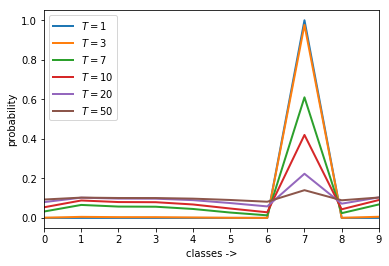

In [10]:
temperatures = [1,3,7,10,20,50]
for temp in temperatures:
    plt.plot((SOFTMAX(teacher_test_logits[0]/temp)), label='$T='+str(temp)+'$', linewidth=2);
    plt.legend();
plt.xlabel('classes ->');
plt.ylabel('probability');
plt.xlim([0, 9]);
plt.show()

## Distillation

In [11]:
input_shape = (28, 28, 1)

In [17]:
##Student model:
nb_classes = y_test.shape[1]
#Feed forward
student_model = tf.keras.models.Sequential()
#Define architecture of the model, add layers:
#input layer:
student_model.add(tf.keras.layers.Flatten(input_shape=input_shape))
#one hidden layers (32 nodes) with reLu activation function.
student_model.add(tf.keras.layers.Dense(32, activation=tf.nn.relu))
# Add Dropout student.add(Dropout(0.2))
#output layer, classification:
student_model.add(tf.keras.layers.Dense(nb_classes))
#student_model.add(tf.keras.layers.Activation('softmax'))
#we could use gradient descent as optimizer
student_model.compile(optimizer='adam', loss ='categorical_crossentropy', metrics = ['accuracy'] )
#model.fit(X_train, y_train, epochs=3)
#student_model.summary()
# print('   ')
# print('   ')
#========================================================================================================

logits = student_model.layers[-1].output
probs = tf.keras.layers.Activation('softmax')(logits)

logits_T = tf.keras.layers.Lambda(lambda x: x / temp)(logits)
probs_T = tf.keras.layers.Activation('softmax')(logits_T)

output = tf.keras.layers.concatenate([probs, probs_T])

student_model = tf.keras.models.Model(student_model.input, output)

student_model.compile(optimizer='adadelta',
                      loss=lambda y_true, y_pred: knowledge_distillation_loss(y_true, y_pred, 0.1),
                      metrics=[acc])
# student_model.summary()

In [14]:
Y_train_soft = SOFTMAX(teacher_train_logits/temp)
Y_test_soft = SOFTMAX(teacher_test_logits / temp)

# 10 + 10 vector = one hot representation + softmax
y_train_new = np.concatenate([y_train, Y_train_soft], axis=1)
y_test_new =  np.concatenate([y_test, Y_test_soft], axis =1)

In [15]:
#continued training.
student_model.fit(x_train, y_train_new,
              batch_size=256,
              epochs=50,
              verbose=1,
              validation_data= (x_test, y_test_new))

Train on 50000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
50000/50000 [==============================] - 1s 30us/sample - loss: 0.0563 - acc: 0.8335 - val_loss: 0.0328 - val_acc: 0.9083
Epoch 2/50
50000/50000 [==============================] - 1s 11us/sample - loss: 0.0276 - acc: 0.9213 - val_loss: 0.0265 - val_acc: 0.9287
Epoch 3/50
50000/50000 [==============================] - 1s 12us/sample - loss: 0.0227 - acc: 0.9359 - val_loss: 0.0240 - val_acc: 0.9343
Epoch 4/50
50000/50000 [==============================] - 1s 12us/sample - loss: 0.0197 - acc: 0.9446 - val_loss: 0.0207 - val_acc: 0.9458
Epoch 5/50
50000/50000 [==============================] - 1s 13us/sample - loss: 0.0177 - acc: 0.9507 - val_loss: 0.0196 - val_acc: 0.9479
Epoch 6/50
50000/50000 [==============================] - 1s 12us/sample - loss: 0.0162 - acc: 0.9541 - val_loss: 0.0181 - val_acc: 0.9544
Epoch 7/50
50000/50000 [==============================] - 1s 13us/sa